# Kaggle Competition - KaKR project

In [1]:
# 시각화를 위한 matplotlib import 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 필요 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# 데이터 경로 지정
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### data preprocessing

In [3]:
# date 전처리해주기 (to int)
# 모델이 date 또한 예측을 위한 특성으로 활용할 수 있다
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# 타겟 데이터에 해당하는 price 컬럼 저일하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

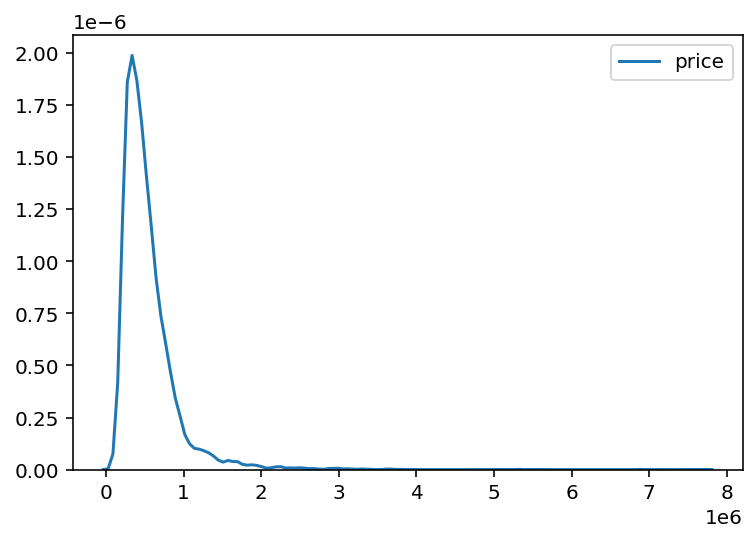

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [7]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

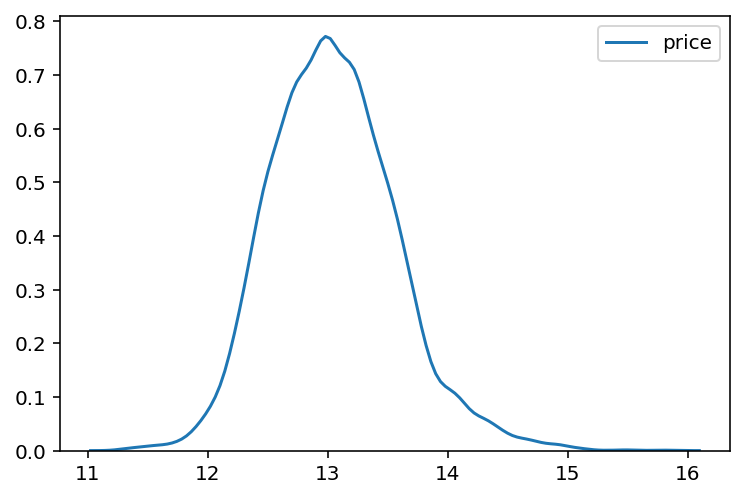

In [8]:
sns.kdeplot(y)
plt.show()

In [9]:
# info()함수로 전체 데이터의 자료형을 한 눈에 확인한다
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [10]:
# RMSE 계산
# 필요 라이브러리 import
# train/test/valid dataset으로 나누기 위한 train_test_split, RMSE점수 계산을 위한 mean_squared_error import

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 모델 가져오기

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


### 그리드 탐색

In [11]:
from sklearn.model_selection import GridSearchCV

random_state=2020

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 모델 준비 - LgitGBM(lbgm)
model = LGBMRegressor(random_state=random_state)

In [12]:
# 그리드탐색을 수행하고 그 결과를 깔끔하게 확인하는 과정을 하나의 함수로 만들기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [13]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 20],
}

# 모델 준비 - LightGBM(lbgm)
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# ==> best 조합 : max_depth=10, n_estimators=150

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    2.6s finished


,max_depth,n_estimators,score,RMSLE
5,10,150,-0.026458,0.162660
8,20,150,-0.026460,0.162666
4,10,100,-0.027027,0.164399
7,20,100,-0.027051,0.164472
3,10,50,-0.029177,0.170814
6,20,50,-0.029198,0.170875
2,1,150,-0.048428,0.220064
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [14]:
# m_d=10, n_estmtrs=150 일떼의 모델로 학습시켜 예측값인 submission.csv파일을 만들어 제출하자

# 위 파라미터로 구성된 모델을 준비하고 학습 후 예측결과를 생성
model = LGBMRegressor(max_depth=10, n_estimator=150)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [15]:
# 예측결과에 np.expm1을 적용하여 원래 스케일로 되돌리는것 잊지 않기!
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [16]:
# sample_submission.csv파일을 가져와 구조 같게 하기
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [17]:
# 저기에 현 모델이 예측한값을 덮어씌우면 제출할 데이터 완성
submission['price']=prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [18]:
# 앞으로 계속 실험을 할 예정이므로 파일 이름에 모델 종류, 위에서 확인했던 RMSLE값을 넣어주면
# 제출파일을 관리하기 용이하다
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [19]:
# 위의 과정 통합하여 함수 만들기
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [20]:
# 이제 한 줄로 모델을 학습시키고 예측 결과를 저장할 수 있다
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


# 직접 튜닝 #1
- learning rate 0.1
- 쓸모없다고 판단된 컬럼 waterfront, zipcde, view, lat, long 제거
### 최종 스코어: 203932.08180

In [21]:
# 데이터 경로 지정
import os
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [22]:
# 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [23]:
# 타겟 데이터에 해당하는 price 컬럼 저일하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)

# ==========
#   custom
# ==========
del train['waterfront']
del train['view']
del train['zipcode']
del train['lat']
del train['long']



# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

# custom
del test['waterfront']
del test['view']
del test['zipcode']
del test['lat']
del test['long']

print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [24]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

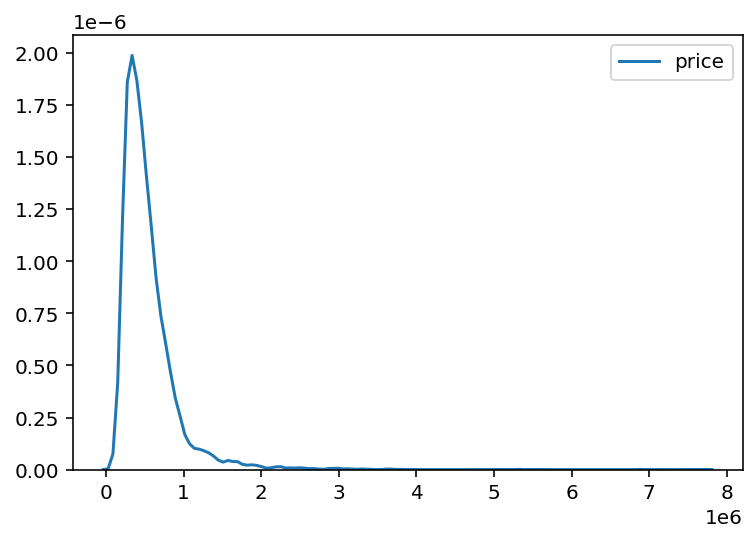

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [25]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

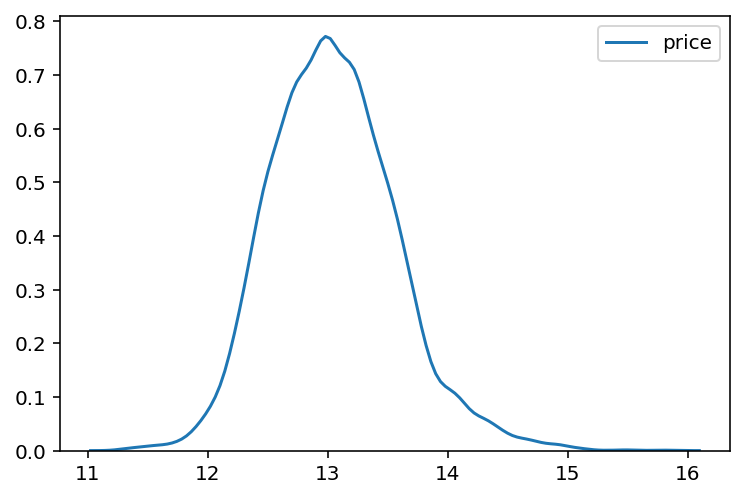

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   condition      15035 non-null  int64  
 7   grade          15035 non-null  int64  
 8   sqft_above     15035 non-null  int64  
 9   sqft_basement  15035 non-null  int64  
 10  yr_built       15035 non-null  int64  
 11  yr_renovated   15035 non-null  int64  
 12  sqft_living15  15035 non-null  int64  
 13  sqft_lot15     15035 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 1.6 MB


In [26]:
# interp
sns.kdeplot(y)
plt.show()

train.info()

In [27]:
# RMSE 계산
# 필요 라이브러리 import
# train/test/valid dataset으로 나누기 위한 train_test_split, RMSE점수 계산을 위한 mean_squared_error import

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 모델 가져오기

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [28]:
from sklearn.model_selection import GridSearchCV

random_state=2020

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [1, 5, 10, 15, 20],
}

# 모델 준비 - LgitGBM(lbgm)
model = LGBMRegressor(random_state=random_state, learning_rate=0.1)

In [29]:
# 그리드탐색을 수행하고 그 결과를 깔끔하게 확인하는 과정을 하나의 함수로 만들기
def my_GridSearch_custom(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [30]:
res = my_GridSearch_custom(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    2.6s finished


In [31]:
res = res.sort_values('RMSLE')
res

,max_depth,n_estimators,score,RMSLE
14,10,100,-0.078417,0.280031
24,20,100,-0.078672,0.280486
19,15,100,-0.078802,0.280717
13,10,70,-0.079020,0.281105
23,20,70,-0.079167,0.281367
18,15,70,-0.079173,0.281378
12,10,50,-0.079785,0.282462
17,15,50,-0.079825,0.282534
22,20,50,-0.079827,0.282537
9,5,100,-0.079828,0.282538


In [32]:
res

,max_depth,n_estimators,score,RMSLE
14,10,100,-0.078417,0.280031
24,20,100,-0.078672,0.280486
19,15,100,-0.078802,0.280717
13,10,70,-0.079020,0.281105
23,20,70,-0.079167,0.281367
18,15,70,-0.079173,0.281378
12,10,50,-0.079785,0.282462
17,15,50,-0.079825,0.282534
22,20,50,-0.079827,0.282537
9,5,100,-0.079828,0.282538


In [33]:
# learning rate 0.001 ~ 0.1
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [34]:
save_submission(model, train, y, test, 'lgbm', rmsle=res['RMSLE'][0])

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.422772596397957.csv saved!


# 시도 #2
- learning rate 0.01
- 쓸모없다고 판단된 컬럼 waterfront, zipcde, view, lat, long 제거
## 최종 스코어 : 275671.22708

In [35]:
# 데이터 경로 지정
import os
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [36]:
# 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [37]:
# 타겟 데이터에 해당하는 price 컬럼 정리하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)

# ==========
#   custom
# ==========
del train['waterfront']
del train['view']
del train['zipcode']
del train['lat']
del train['long']



# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

# custom
del test['waterfront']
del test['view']
del test['zipcode']
del test['lat']
del test['long']

print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


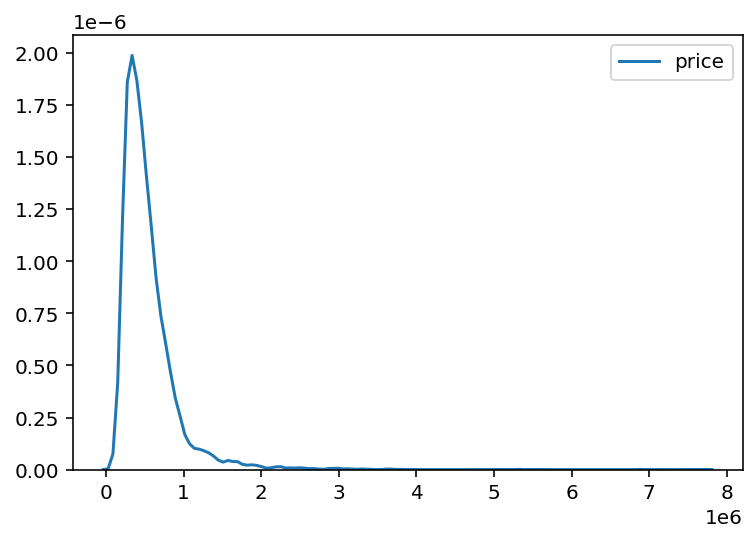

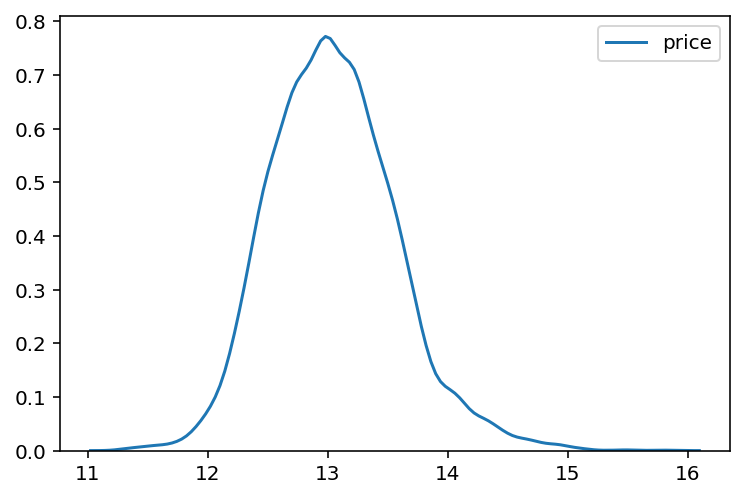

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   condition      15035 non-null  int64  
 7   grade          15035 non-null  int64  
 8   sqft_above     15035 non-null  int64  
 9   sqft_basement  15035 non-null  int64  
 10  yr_built       15035 non-null  int64  
 11  yr_renovated   15035 non-null  int64  
 12  sqft_living15  15035 non-null  int64  
 13  sqft_lot15     15035 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 1.6 MB


In [38]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

# interp
sns.kdeplot(y)
plt.show()

train.info()

In [39]:
# gridsearch
from sklearn.model_selection import GridSearchCV

random_state=2020

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [1, 5, 10, 15, 20],
}

# 모델 준비 - LgitGBM(lbgm)
model = LGBMRegressor(random_state=random_state, learning_rate=0.01)

In [40]:
res = my_GridSearch_custom(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    2.8s finished


In [41]:
res = res.sort_values('RMSLE')
res.head(10)

,max_depth,n_estimators,score,RMSLE
24,20,100,-0.119039,0.345020
19,15,100,-0.119039,0.345020
14,10,100,-0.119039,0.345020
9,5,100,-0.120589,0.347259
18,15,70,-0.141562,0.376247
13,10,70,-0.141562,0.376247
23,20,70,-0.141562,0.376247
8,5,70,-0.142891,0.378010
22,20,50,-0.164614,0.405727
17,15,50,-0.164614,0.405727


In [42]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [43]:
save_submission(model, train, y, test, 'lgbm', rmsle=res['RMSLE'][0])

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.5116804593985506.csv saved!


# 시도 #3
- learning rate 0.1
- 쓸모없다고 판단된 컬럼 waterfront, zipcde, view, lat, long 들 제거하지 않기
### 최종 점수: 113112.14053

In [44]:
# 데이터 경로 지정
import os
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [45]:
# 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [46]:
# 타겟 데이터에 해당하는 price 컬럼 저일하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)



# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


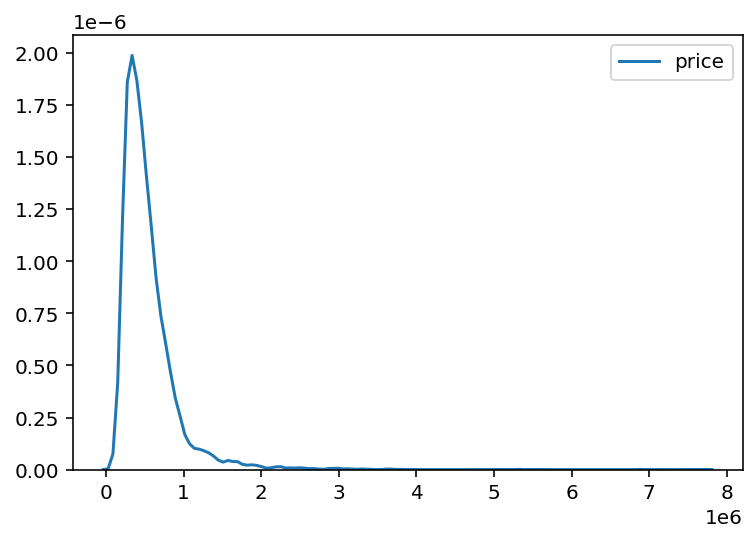

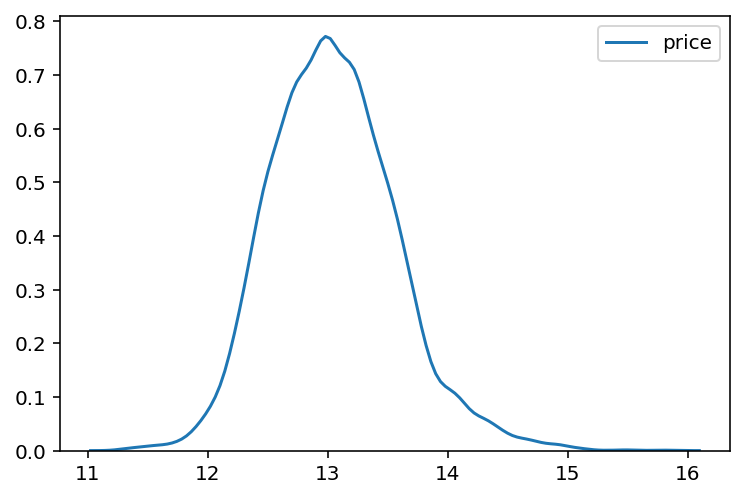

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [47]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

# interp
sns.kdeplot(y)
plt.show()

train.info()

In [48]:
# gridsearch
from sklearn.model_selection import GridSearchCV

random_state=2020
learning_rate = 0.1

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [1, 5, 10, 15, 20],
}

# 모델 준비 - LgitGBM(lbgm)
model = LGBMRegressor(random_state=random_state, learning_rate=learning_rate)

In [49]:
res = my_GridSearch_custom(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    3.1s finished


In [50]:
res = res.sort_values('RMSLE')
res

,max_depth,n_estimators,score,RMSLE
14,10,100,-0.027027,0.164399
24,20,100,-0.027051,0.164472
19,15,100,-0.027174,0.164845
13,10,70,-0.027834,0.166836
23,20,70,-0.027848,0.166876
18,15,70,-0.027910,0.167062
9,5,100,-0.028797,0.169696
17,15,50,-0.029170,0.170792
12,10,50,-0.029177,0.170814
22,20,50,-0.029198,0.170875


In [51]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [52]:
save_submission(model, train, y, test, 'lgbm', rmsle=res['RMSLE'][0])

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.4038391109286722.csv saved!


# 시도 4
- learning rate 0.1
- model: lightgbm -> xgboost
## 최종 점수: 118442.58300
-> lightbgm이 더 빠르다

In [53]:
# 다시 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [54]:
# 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [55]:
# 타겟 데이터에 해당하는 price 컬럼 정리하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)



# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


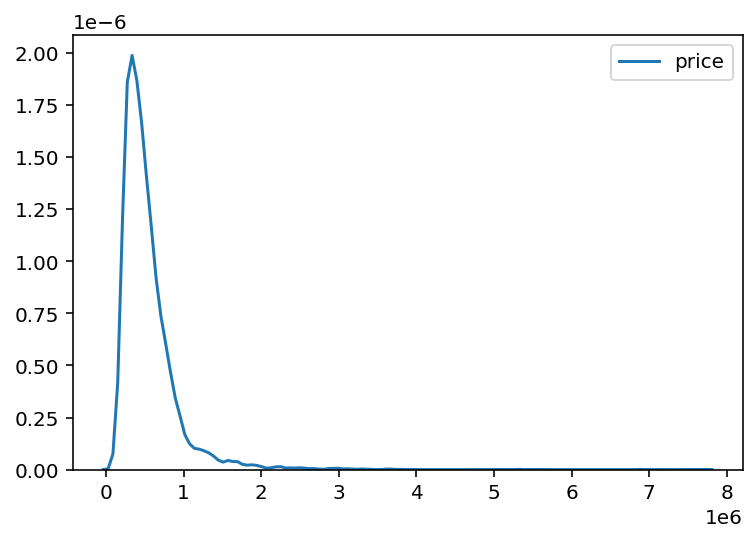

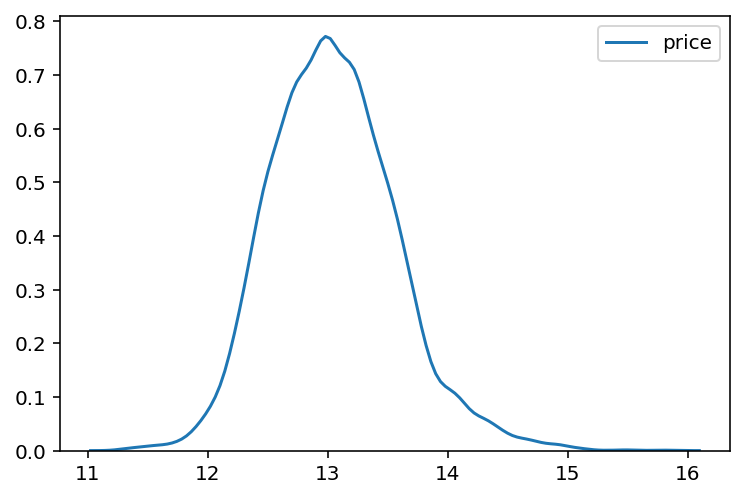

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [56]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

# interp
sns.kdeplot(y)
plt.show()

train.info()

In [57]:
# gridsearch
from sklearn.model_selection import GridSearchCV

random_state=2020
learning_rate = 0.01

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [1, 5, 10, 15, 20],
}

# 모델 준비 - XGBoost
from xgboost import XGBRegressor

model = XGBRegressor(random_state=random_state)

In [58]:
res = my_GridSearch_custom(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:   17.7s finished


In [59]:
res = res.sort_values('RMSLE')
res

,max_depth,n_estimators,score,RMSLE
9,5,100,-0.028205,0.167945
8,5,70,-0.028747,0.169550
7,5,50,-0.029601,0.172048
12,10,50,-0.030349,0.174210
13,10,70,-0.030358,0.174234
11,10,30,-0.030412,0.174391
14,10,100,-0.030470,0.174557
6,5,30,-0.031860,0.178492
17,15,50,-0.032470,0.180195
18,15,70,-0.032472,0.180199


In [60]:
save_submission(model, train, y, test, 'xgb', rmsle=res['RMSLE'][0])

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_xgb_RMSLE_0.46439848942559325.csv saved!


# 시도 5
- 학습률 0.1
- lgbm param tuning) d
- sqft당(sqft_above) 가격 feature 추가
## 최종 점수[private/public]: 115214.94957 113112.14053

In [119]:
# 다시 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/e/e08_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [120]:
# 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [121]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

<AxesSubplot:>

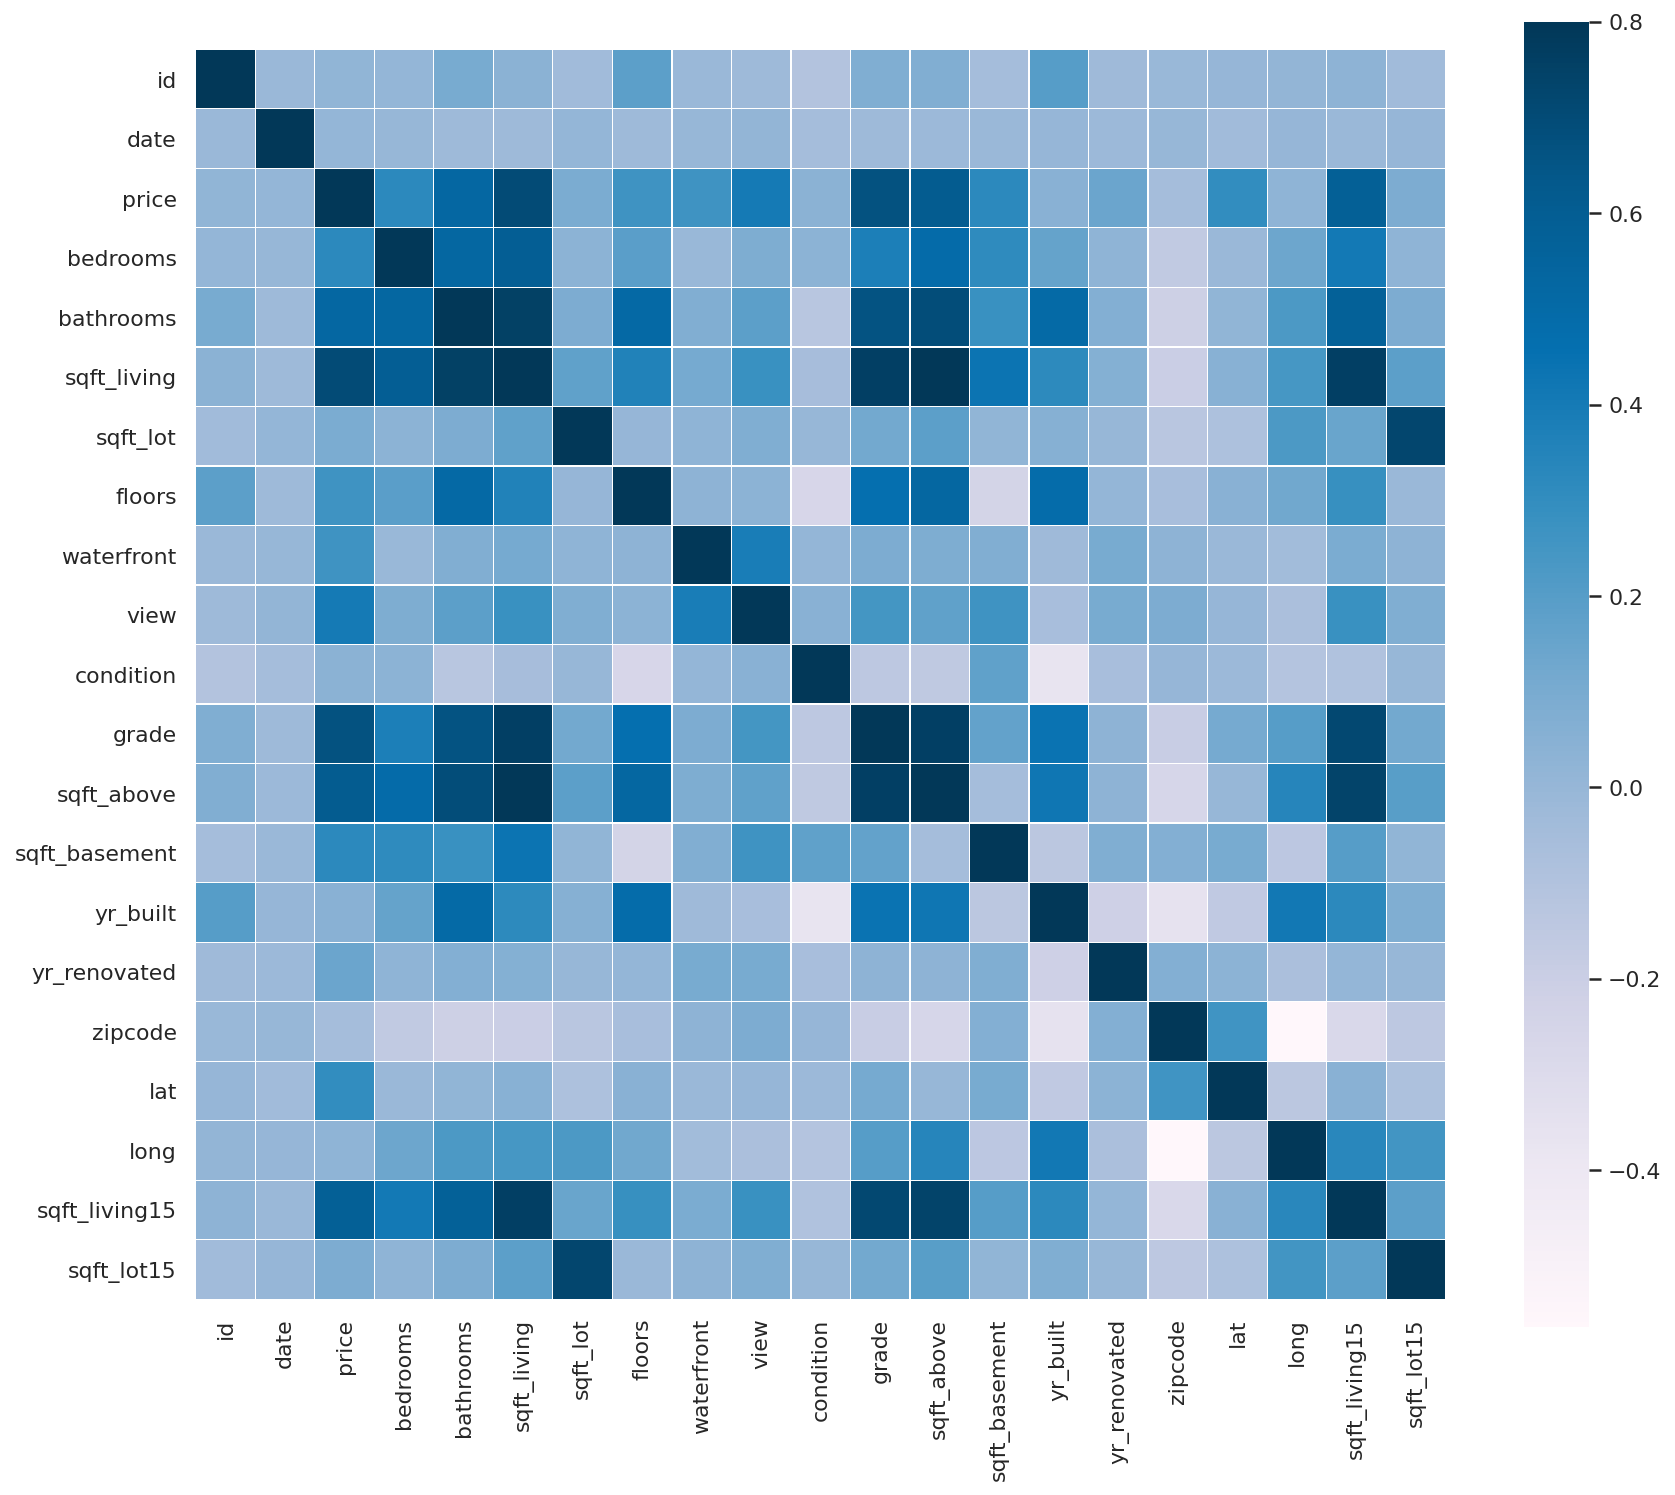

In [122]:
# corr heatmap
corr = train[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]
colormap = plt.cm.PuBu
sns.set(font_scale=1.0)

f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr.corr(), square=True, linewidths=0.1,
           cmap=colormap, linecolor="white", vmax=0.8)

### -> price 상관분석 히트맵 상에서 sqft_living, grade, bathrooms, view, sqft_above, sqft_living15, lat이 관련도가 높음을 확인할 수 있다
- sqft_living
- grade
- view
- lat    
위주로 피처엔지니어링 해 보기

In [123]:
train['grade'].describe()

count    15035.000000
mean         7.660725
std          1.179803
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

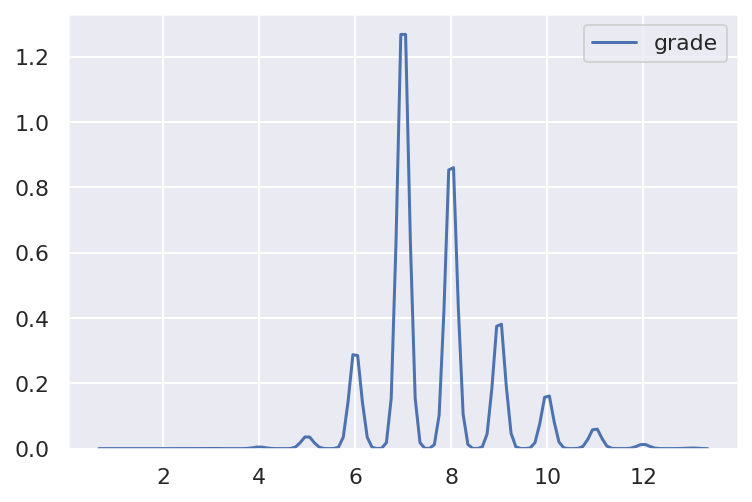

In [124]:
# grade 분포 확인하기
sns.kdeplot(train['grade'])
plt.show()

In [125]:
print(train[train['grade'] >= 11]['price'].mean())
print(train[train['grade'] < 4]['price'].mean())

1707017.0782122905
228000.0


In [126]:
train.sort_values(by=['price'], ascending=0)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
2775,2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
6469,6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
3134,3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
1045,1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674,2674,201504,84000.0,2,1.00,700,20130,1.0,0,0,...,6,700,0,1949,0,98168,47.4752,-122.271,1490,18630
12841,12841,201405,83000.0,2,1.00,900,8580,1.0,0,0,...,5,900,0,1918,0,98168,47.4727,-122.270,2060,6533
11293,11293,201503,81000.0,2,1.00,730,9975,1.0,0,0,...,5,730,0,1943,0,98168,47.4808,-122.315,860,9000
339,339,201405,80000.0,1,0.75,430,5050,1.0,0,0,...,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500


In [127]:
# 타겟 데이터에 해당하는 price 컬럼 정리하기
# y 변수에 price를 넣어두고 train에선 삭제하기
y = train['price']
del train['price']

print(train.columns)

# id컬럼도 삭제해두기
del train['id']

print(train.columns)

## ======= 커스텀 =======
del train['zipcode']
del train['waterfront']




# 위 작업을 test데이터에 대해서도 동일하게!
# 단, price가 없으므로 price처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
print(test.columns)

## ======= 커스텀 =======
del test['zipcode']
del test['waterfront']

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [128]:
train.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,201438.545993,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,47.560721,-122.213677,1992.754772,12823.884935
std,44.252050,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,0.138164,0.141294,691.456442,27736.259787
min,201405.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,201407.000000,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,201410.000000,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,201502.000000,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,47.678300,-122.126000,2360.000000,10076.000000
max,201505.000000,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


In [129]:
# 결측치 확인 
train.isnull().sum() / train.shape[0]

date             0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

In [130]:
test.isnull().sum()/test.shape[0]

date             0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

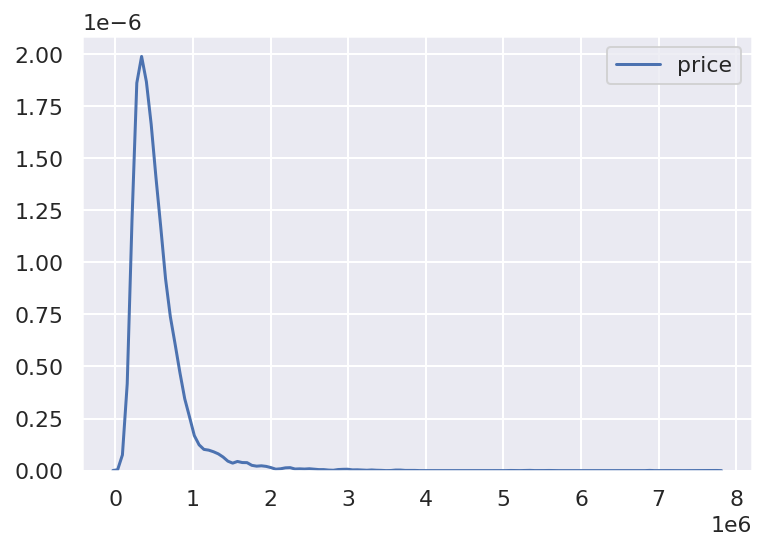

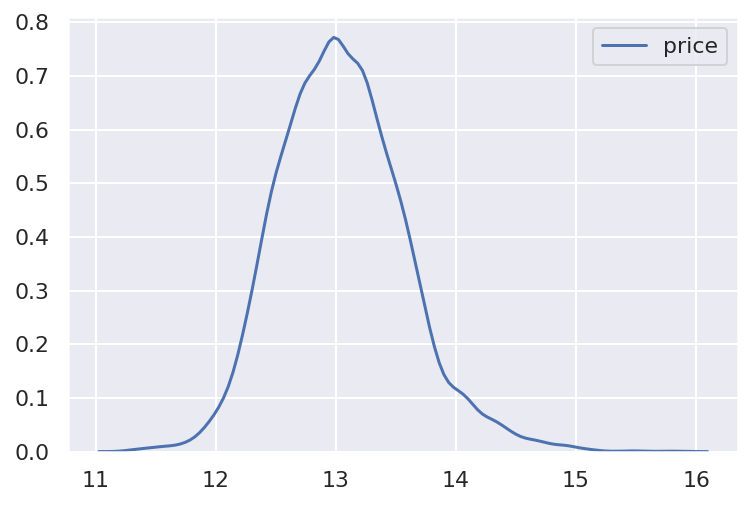

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  int64  
 10  sqft_basement  15035 non-null  int64  
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  lat            15035 non-null  float64
 14  long           15035 non-null  float64
 15  sqft_living15  15035 non-null  int64  
 16  sqft_lot15     15035 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 2.0 MB


In [131]:
# 가격 데이터 분포 확인하기
sns.kdeplot(y)
plt.show()
# ==> 왼쪽으로 크게 치우쳐 있는 형태를 보인다

y = np.log1p(y)
y

# interp
sns.kdeplot(y)
plt.show()

train.info()

In [132]:
# gridsearch
from sklearn.model_selection import GridSearchCV

random_state=2020
learning_rate = 0.1

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 150, 300],
    'max_depth': [10, 30, 50],
    'num_leaves': [10, 50]
}

# 모델 준비 - LgitGBM(lbgm)
model = LGBMRegressor(random_state=random_state, learning_rate=learning_rate)

In [133]:
res = my_GridSearch_custom(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   12.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:   16.6s finished


In [134]:
res = res.sort_values('RMSLE')
res

,max_depth,n_estimators,num_leaves,score,RMSLE
5,10,150,50,-0.027309,0.165253
17,30,150,50,-0.027360,0.165408
29,50,150,50,-0.027360,0.165408
9,10,300,50,-0.027381,0.165472
33,50,300,50,-0.027452,0.165687
21,30,300,50,-0.027452,0.165687
6,10,150,100,-0.027745,0.166567
30,50,150,100,-0.027775,0.166659
18,30,150,100,-0.027801,0.166737
8,10,300,10,-0.027901,0.167037


In [135]:
save_submission(model, train, y, test, 'lgbm', rmsle=res['RMSLE'][0])

/home/aiffel/aiffel/e/e08_kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1883019511292452.csv saved!
